# CPEN 346 - Midterm Project

Author: Matthew VonWahlde  
Date: 10/12/2023  
</nbsp>  
In this project, I will implement logistic regression with regularization and apply it to the Wisconsin Diagnostic Breast Cancer (WDBC) dataset.

### Packages

First, the necessary packages are imported into the project:  
* Numpy - Implements parallel computing in arrays
* Matplotlib - Convenient data plotting
* Math - Useful mathematical functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

### Load Data from WDBC

Firstly, the dataset from WDBC needs to be loaded into this project, so it can be used for training and testing. This dataset contains 569 examples of breast cancer tumors (357 benign, 212 malignant) with each having an ID, diagnosis, and 30 real-valued input features.

In [2]:
def load_data(filename):
    """
    Loads and formats data from the WDBC dataset
    
    Args:
      filename : relative path for the file that holds the data
      
    Returns:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) outputs, 1 == malignant, 0 == benign
    """
    # Load the data from the file
    data = np.loadtxt(filename, dtype=str, delimiter=',')
    
    # Store the 30 features from each example into a 2D matrix and convert the type to float
    X = data[:,2:32]
    X = X.astype(float)
    
    # Store the outputs for each example and set each 'M' to a 1 and each 'B' to a 0
    y_tmp = data[:,1]
    numRows = y_tmp.shape[0]
    y = np.zeros(numRows)
    
    for i in range(0, numRows):
        # For each output, set to 1 if 'M' or 0 if 'B'
        if y_tmp[i] == 'M':
            y[i] = 1
        else:
            y[i] = 0
    
    # Return data and outputs
    return X, y

In [3]:
# Load dataset
X_train, y_train = load_data("./data/wdbc.data")

### Z-Score Normalization

To speed up the learning process, feature scaling will be implemented. In particular, Z-Score Normalization will be the method used to feature scale.  
</nbsp>  
Feature scaling is the act of altering the value of features, so they are all in a consistent range. If one particular feature is much larger than others, it will dominate when computing the output. Keeping a consistent scale among features will allow each feature to have significance when computing the prediction.  
</nbsp>  
Z-score normalization is a method of feature scaling that modifies each feature based on its mean and standard deviation.
$$ x_{j,scaled} = \frac{x_j - M_j}{\sigma_j}$$
This equation represents the equation to calculate each scaled feature. Note the M denotes the mean, $\sigma$ denotes standard deviation, and j denotes the $j^{th}$ feature.

In [4]:
def calc_mean_stddev(data):
    """
    Calculates the mean and standard deviation for each feature in the data set
    
    Args:
      data : (ndarray Shape (m,n)) data, m examples by n features
      
    Returns:
      means     : (ndarray) mean of each feature
      deviations: (ndarray) standard deviation of each feature
    """
    # Rows and columns of the dataset
    rows, cols = data.shape
    
    # Preallocate arrays for the mean and standard deviations
    means = np.zeros(cols)
    deviations = np.zeros(cols)
    
    # Calculate each mean and start deviation
    for i in range(0, cols):
        means[i] = np.mean(data[:,i])
        deviations[i] = np.std(data[:,i])
    
    return means, deviations 
    

In [5]:
def Z_score_norm(data):
    """
    Feature scales the dataset using z-score normalization.
    
    Args:
      data : (ndarray Shape (m,n)) data, m examples by n features
      
    Returns:
      data : (ndarray Shape (m,n)) data, m examples by n features (z-score normalized)
      dev
    """
    # Calculate the mean and stardard deviation
    mean, std_dev = calc_mean_stddev(X_train)
    
    rows, cols = data.shape

    # For each feature in the dataset, perform z-score normalization
    for i in range(0, cols):
        data[:, i] = (data[:, i] - mean[i]) / std_dev[i]
        
    return data
    

In [6]:
# Use z-score normalization to feature scale
X_train = Z_score_norm(X_train)

### Sigmoid Function

In logistic regression, the sigmoid function is used to "squish" the input data into a function that is between 0 and 1. When the input value heads toward negative infinity, the sigmoid function heads toward 0. When the input value heads toward positive infinity, the sigmoid function heads toward 1.  
</nbsp>  
$$ g(z) = \frac{1}{1 + e^{-z}} \quad 0 < g(z) < 1 $$  
</nbsp>  
The term z refers to the expression, $ \vec{w} \cdot \vec{x} + b $, used in linear regression.  

In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
    # Calculate the sigmoid output for each scalar input
    g = 1 / (1 + np.exp(-1 * z))  
    
    return g

### Cost Function for Logistic Regression with Regularization

The cost function for logistic regression with regularization is similar to logistic expression, but with an extra term at the end.  
</nbsp>
$$ J(\vec{w}, b) = \frac{-1}{m} \sum_{i=1}^{m} [ y^{(i)}log(f_{(\vec{w}, b)}(\vec{x}^{(i)})) + (1 - y^{(i)})log(f_{(\vec{w}, b)}(\vec{x}^{(i)})) ] + \frac{\lambda}{2m}\sum_{j=1}^{n}w_j^2 $$
$$ f_{\vec{w},b}(\vec{x}) = g(z) $$
</nbsp>  
This extra term is the regularization term, with the constant $\lambda$ representing the regularization parameter. The addition of the regularization term helps balance two goals: fitting the data and keeping $w_j$ small. When $\lambda$ is large, $w_j$ must be small to minimize cost.

In [8]:
def compute_cost(X, y, w, b, lambda_):
    """
    Computes the cost over all examples
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: regularization constant
      
    Returns:
      total_cost: (scalar)         cost 
    """
    # Get shape and set initial cost to 0
    m, n = X.shape
    total_cost = 0
    
    # For each example in the dataset
    for i in range(0,m):
        # Compute the output prediction
        z = np.dot(w, X[i,:]) + b
        g = sigmoid(z)
        # Used to prevent floating point error from giving log function an input of 0
        if (1-g) <= 0.00000000001:
            g -= 0.00000000001
        # Add cost for each example
        total_cost += -1*y[i]*math.log(g) - (1-y[i])*math.log(1-g)
    
    total_cost /= m
    
    # Add regularization term
    total_cost += ( lambda_ / (2*m) ) * np.dot(w, w)

    return total_cost

### Computing the gradient

Adding the regularization term adds one term to the end of the gradient function when calculating the derivative with respect to $w_j$, but the derivative with respect to b remains the same.  
</nbsp>  
$$ \frac {\partial J(\vec{w},b)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} [(f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})x_j^{(i)}] + \frac{\lambda}{m}w_j $$
$$ \frac {\partial J(\vec{w},b)}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} [(f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})] $$  
$$ f_{\vec{w},b}(\vec{x}) = g(z) $$

In [9]:
def compute_gradient(X, y, w, b, lambda_): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: regularization constant
      
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    # Get shape and preallocate initial derivatives
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    # For each example, compute the change in the derivative for w and b
    for i in range(0, m):
        z = np.dot(w, X[i,:]) + b
        g = sigmoid(z)

        dj_dw += np.dot(g - y[i], X[i,:])
        dj_db += g - y[i]
       
    dj_dw /= m
    dj_db /= m
    
    # Add regularization term
    dj_dw += (lambda_ / m) * w
        
    return dj_db, dj_dw

### Gradient Descent

The formula for gradient descent for logistic regression is as follows. Note that you should not update $w_j$ until b has been updated as to not use the new values of $w_j$ when computing b's gradient.  
</nbsp>  
repeat until convergence (or a set number of iterations) {  
$ \quad w_j = w_j - \alpha \frac{\partial J(\vec{w}, b)}{\partial w_j} $  
$ \quad b = b - \alpha \frac{\partial J(\vec{w}, b)}{\partial b} $  
}

In [10]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

### Testing

When testing out the logistic regression with regularization, you can alter the number of iterations, alpha, lambda, the random seed, and the initial b to see what provides the highest accuracy. In the future, it would be beneficial to use some data for training and some data for testing. This way, you can tell when the training data is overfit.

In [11]:
# Set random seed, inital w, and initial b
np.random.seed(20)
initial_w = 0.01 * (np.random.rand(30).reshape(-1) - 0.5)
initial_b = 8

# Some gradient descent settings
iterations = 10000
alpha = 1
lambda_ = .1

# Perform gradient descent
w,b, J_history,_ = gradient_descent(X_train, y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, lambda_)

Iteration    0: Cost     2.66   
Iteration 1000: Cost     0.05   
Iteration 2000: Cost     0.05   
Iteration 3000: Cost     0.05   
Iteration 4000: Cost     0.05   
Iteration 5000: Cost     0.05   
Iteration 6000: Cost     0.05   
Iteration 7000: Cost     0.05   
Iteration 8000: Cost     0.05   
Iteration 9000: Cost     0.05   
Iteration 9999: Cost     0.05   


In [12]:
def plot_cost_versus_iteration(J_hist):
    """
    Creates a plot of the cost at each iteration of gradient descent
    
    Args:
      J_hist : (ndarray) array of costs at each iteration
      
    Returns:
      None
    """
    # Plot the cost versus iteration
    plt.plot(J_hist, c='b',label='Cost')
    plt.title("Cost vs. iteration"); 
    plt.ylabel('Cost')             ;  
    plt.xlabel('iteration step')   ;  
    plt.show()

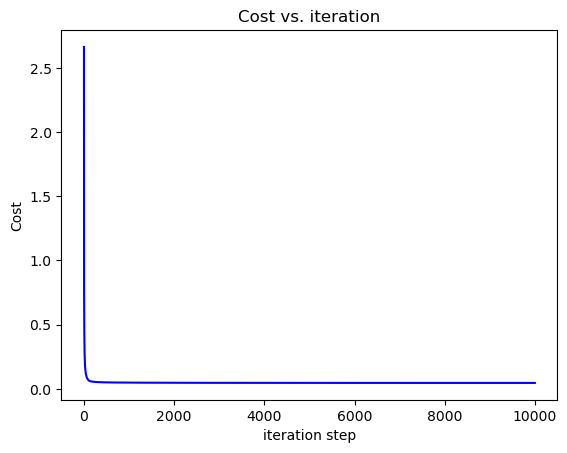

In [13]:
# Plot cost versus iteration
plot_cost_versus_iteration(J_history)

### Accuracy

In the following section, the accuracy of the model is tested, comparing the predicted output with the real diagnosis. The accuracy should be around 99.1%.

In [14]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    # For each example, give a prediction
    for i in range(0, m):
        z = np.dot(w, X[i,:]) + b
        g = sigmoid(z)
    
        p[i] = 1 if g >= 0.5 else 0
        
    return p

In [15]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Training Accuracy: %f'%(np.mean(p == y_train) * 100))

Training Accuracy: 99.121265
